In [24]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from mpl_toolkits.basemap import Basemap as Basemap
from geopy.geocoders import Nominatim

In [25]:
# calling the Nominatim tool
loc = Nominatim(user_agent="GetLoc")
 
# entering the location name
getLoc = loc.geocode("Inglewood, CA")
 
# printing address
print(getLoc.address)
 
# printing latitude and longitude
print("Latitude = ", getLoc.latitude)
print("Longitude = ", getLoc.longitude)

Inglewood, Los Angeles County, California, United States
Latitude =  33.9562003
Longitude =  -118.353132


In [26]:
def getGeo(city, state):
    getLoc = loc.geocode(f"{city}, {state}")
    return getLoc.latitude, getLoc.longitude

In [27]:
college = 'ucla'

offers = pd.read_csv(f"data/offers/{college}_offers.csv")
offers['lat'], offers['long'] = zip(*offers.apply(lambda row : getGeo(row['city'],row['state']), axis = 1))

In [28]:
commits = pd.read_csv(f"data/commits/{college}_commits.csv")
commits['col'] = college

In [29]:
offers['col'] = college
offers.head()

,name,school,city,state,lat,long,col
0,Raleek Brown,Mater Dei,Santa Ana,CA,33.749495,-117.873221,ucla
1,Jaydn Ott,Norco,Norco,CA,33.932331,-117.550890,ucla
2,Tomarion Harden,Inglewood,Inglewood,CA,33.956200,-118.353132,ucla
3,Tetairoa McMillan,Servite,Anaheim,CA,33.834752,-117.911732,ucla
4,C.J. Williams,Mater Dei,Santa Ana,CA,33.749495,-117.873221,ucla


In [30]:
offers_hs = offers['school'].value_counts().reset_index(name = 'weight')
commits_hs = commits['school'].value_counts().reset_index(name = 'weight')

offers_hs['col'] = college
commits_hs['col'] = college

offers_hs['weight'] = offers_hs['weight']
commits_hs['weight'] = commits_hs['weight']

offers_hs.head()

,index,weight,col
0,Mater Dei,7,ucla
1,Bishop Gorman,4,ucla
2,Inglewood,3,ucla
3,Bishop Alemany,3,ucla
4,St. John Bosco,2,ucla


In [31]:
offers_edgelist = pd.merge(offers_hs, offers[['school', 'city', 'state', 'lat', 'long']], left_on='index', right_on='school')
offers_edgelist = offers_edgelist.drop_duplicates().drop(['index'], axis = 1)

commits_edgelist = pd.merge(commits_hs, offers[['school', 'city', 'state', 'lat', 'long']], left_on='index', right_on='school')
commits_edgelist = commits_edgelist.drop_duplicates().drop(['index'], axis = 1)

In [32]:
commits_edgelist.columns

Index(['weight', 'col', 'school', 'city', 'state', 'lat', 'long'], dtype='object')

In [33]:
G_offer = nx.from_pandas_edgelist(offers_edgelist, source = 'col', target = 'school', edge_attr='weight', create_using = nx.DiGraph())
G_commit = nx.from_pandas_edgelist(commits_edgelist, source = 'school', target = 'col', edge_attr='weight',create_using = nx.DiGraph())

In [34]:
G = nx.compose(G_offer, G_commit)

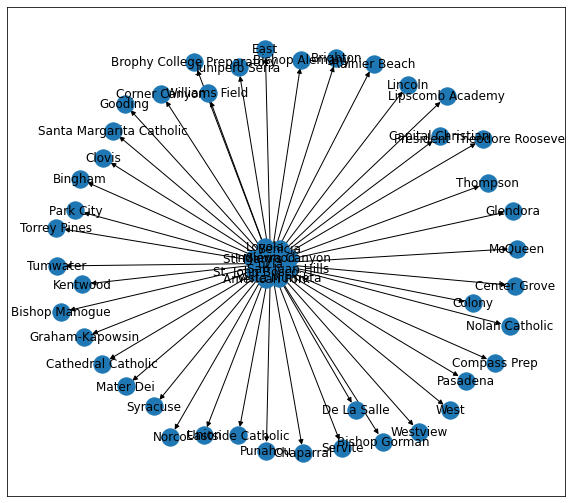

In [35]:
plt.figure(figsize = (10,9))
nx.draw_networkx(G)
# plt.savefig("./images/map_0.png", format = "png", dpi = 300)
plt.show()

In [122]:
plt.figure(figsize = (10,9))

# Full US
# m = Basemap(llcrnrlon=-119,llcrnrlat=20,urcrnrlon=-64,urcrnrlat=49,projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

# California zoom
m = Basemap(llcrnrlon=-123,llcrnrlat=30,urcrnrlon=-110,urcrnrlat=53,projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

<Figure size 720x648 with 0 Axes>

In [123]:
mx, my = m(offers_edgelist['long'], offers_edgelist['lat'])

In [124]:
pos = {}
for count, elem in enumerate(offers_edgelist['school']):
    pos[elem] = (mx[count], my[count])

In [125]:
# lat, long = getGeo('Tuscaloosa', 'AL')
lat, long = getGeo('Westwood', 'CA')
pos[f'{college}'] = m(long, lat)

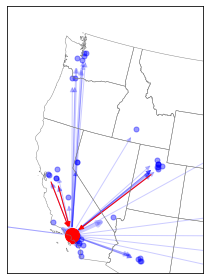

In [126]:
nx.draw_networkx_edges(G_offer, pos = pos, edge_color='blue',
                        alpha=0.2, arrows = True, width=list(nx.get_edge_attributes(G_offer, 'weight').values()))
nx.draw_networkx_edges(G_commit, pos = pos, edge_color='red',
                        alpha=1, arrows = True, width=list(nx.get_edge_attributes(G_commit, 'weight').values()))
nx.draw_networkx_nodes(G, pos = pos, nodelist = G.nodes(), 
                        node_color = 'blue', alpha = 0.4, node_size = 25)
nx.draw_networkx_nodes(G, pos = pos, nodelist = [college], 
                        node_color = 'red', alpha = 1, node_size = 200)

shp_info = m.readshapefile('st99_d00','states',drawbounds=True,
                           linewidth=0.45,color='gray')

plt.tight_layout()
# plt.savefig("./images/map_1.png", format = "png", dpi = 300)
plt.show()